In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, activations
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from keras_tuner import RandomSearch

np.set_printoptions(precision = 3, suppress = True)

In [2]:
sim_data = pd.read_csv("ES_EZ_Call_Sim.csv")
df = sim_data.drop(['Unnamed: 0', 'Stock price', 'Dividend rate'], axis = 1)
df.head()

,Strike price,Maturity,Risk free rate,Volatility,Call Price
0,2.0,0.01,0.0002,0.132805,98.000004
1,2.0,0.01,0.0002,0.505282,98.000004
2,2.0,0.01,0.0002,0.377539,98.000004
3,2.0,0.01,0.0002,0.223472,98.000004
4,2.0,0.01,0.0002,0.622247,98.000004


In [3]:
X = df[df.columns.values[:-1]]
y = df['Call Price']

X_train, X_test, y_train, y_test = train_test_split(X.copy(), y, test_size = 0.2, random_state = 123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((896800, 4), (224200, 4), (896800,), (224200,))

In [4]:
# Standardize the features
scalerX = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scalerX.transform(X_train), columns = X.columns.values) 
X_test = pd.DataFrame(scalerX.transform(X_test), columns = X.columns.values) 

scalery = MinMaxScaler().fit(y_train.values.reshape(-1, 1))
y_train = scalery.transform(y_train.values.reshape(-1, 1))
y_test = scalery.transform(y_test.values.reshape(-1, 1))

In [5]:
np.random.seed(123)
tf.random.set_seed(123)

In [6]:
def plot_loss(history):
    plt.figure(figsize = (8,6))
    plt.plot(history.history['loss'], label = 'loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)
    
def plot_time(time):
    print('The total training time is {} seconds.'.format(np.round(np.sum(time), 1)))
    plt.figure(figsize = (8,6))
    plt.plot(np.arange(1, len(time) + 1), time)
    plt.xlabel('Epoch')
    plt.ylabel('Time for each epoch')
    plt.grid(True)

In [7]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs = {}):
        self.times = []

    def on_epoch_begin(self, batch, logs = {}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs = {}):
        self.times.append(time.time() - self.epoch_time_start)

In [8]:
learning_rate = [1e-2, 1e-3, 1e-4]
History = []
times = []
earlyStop = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)
for lr in learning_rate:
    model = models.Sequential()
    # Input layer
    model.add(layers.Dense(units = 4))

    # first layer
    model.add(layers.Dense(units = 100))
    model.add(BatchNormalization())
    model.add(layers.Activation(activations.elu))
    model.add(layers.Dropout(0.25))

    # second layer
    model.add(layers.Dense(units = 100))
    model.add(BatchNormalization())
    model.add(layers.Activation(activations.elu))
    model.add(layers.Dropout(0.25))

#     # third layer
#     model.add(layers.Dense(units = 100))
#     model.add(BatchNormalization())
#     model.add(layers.Activation(activations.elu))
#     model.add(layers.Dropout(0.25))

    # Output layer
    model.add(layers.Dense(units = 1, activation = "exponential"))

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = lr), loss = "mean_squared_error"
    )
    
    time_callback = TimeHistory()

    history = model.fit(X_train, 
        y_train, 
        epochs = 100, 
        verbose = 0,
        batch_size = 64, 
        callbacks = [earlyStop, time_callback],
        validation_split = 0.2)
    BSNN_train_pred = model.predict(X_train)
    BSNN_test_pred = model.predict(X_test)
    print('When the learning rate is', lr)
    print("The training R squared is", 
          np.round(r2_score(y_train, BSNN_train_pred), 4))
    print("The testing R squared is", 
          np.round(r2_score(y_test, BSNN_test_pred), 4))
    print('-------------------------------------------------------------------')
    History.append(history)
    times.append(time_callback.times)
    path = "/Users/gaojinglun/Desktop/RSG/ES_EZ_ANN_call_withLR" + str(lr)
    model.save(path)

When the learning rate is 0.01
The training R squared is 0.9895
The testing R squared is 0.9894
-------------------------------------------------------------------
INFO:tensorflow:Assets written to: /Users/gaojinglun/Desktop/RSG/ES_EZ_ANN_call_withLR0.01/assets
When the learning rate is 0.001
The training R squared is 0.9979
The testing R squared is 0.9979
-------------------------------------------------------------------
INFO:tensorflow:Assets written to: /Users/gaojinglun/Desktop/RSG/ES_EZ_ANN_call_withLR0.001/assets
When the learning rate is 0.0001
The training R squared is 0.9974
The testing R squared is 0.9974
-------------------------------------------------------------------
INFO:tensorflow:Assets written to: /Users/gaojinglun/Desktop/RSG/ES_EZ_ANN_call_withLR0.0001/assets


In [9]:
path1 = "/Users/gaojinglun/Desktop/RSG/ES_EZ_ANN_call_withLR" + str(learning_rate[0])
ANN_lr1 = keras.models.load_model(path1)
path2 = "/Users/gaojinglun/Desktop/RSG/ES_EZ_ANN_call_withLR" + str(learning_rate[1])
ANN_lr2 = keras.models.load_model(path2)
path3 = "/Users/gaojinglun/Desktop/RSG/ES_EZ_ANN_call_withLR" + str(learning_rate[2])
ANN_lr3 = keras.models.load_model(path3)

### With learning rate 1e-3

The total training time is 165.7 seconds.


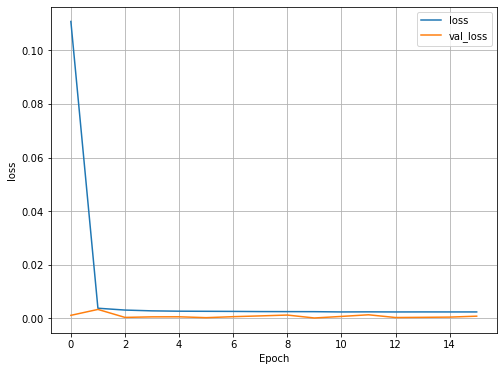

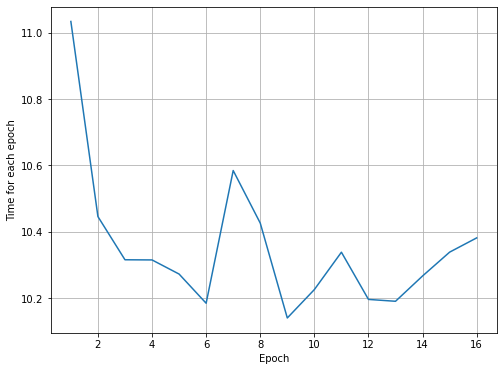

In [10]:
plot_loss(History[0])
plot_time(times[0])

### With learning rate 1e-4

The total training time is 269.6 seconds.


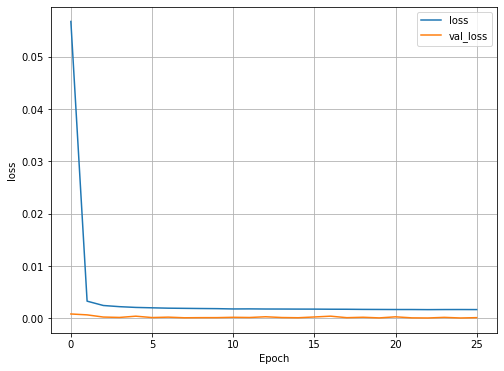

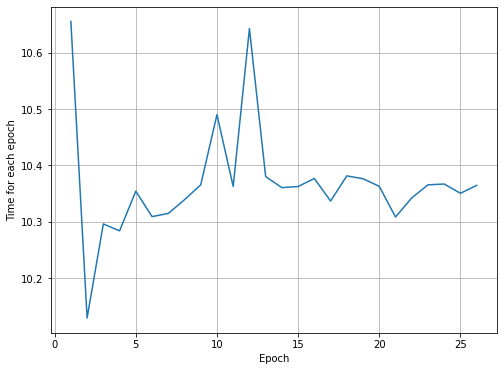

In [11]:
plot_loss(History[1])
plot_time(times[1])

### With learning rate 1e-5

The total training time is 382.4 seconds.


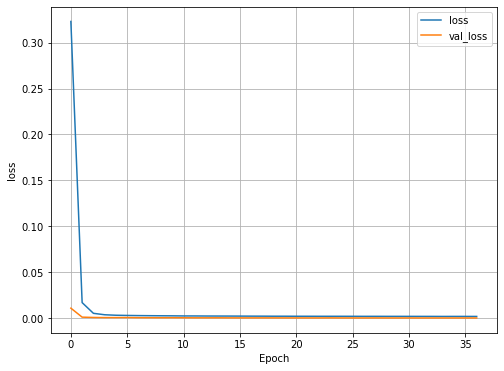

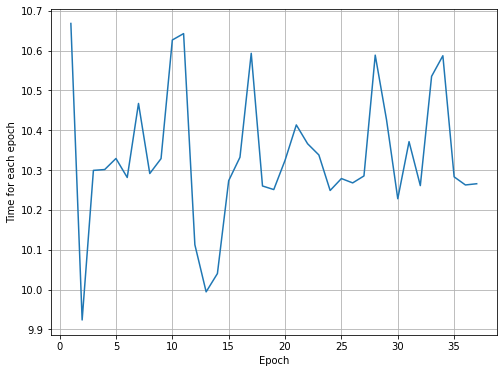

In [12]:
plot_loss(History[2])
plot_time(times[2])